In [1]:
%load_ext autoreload
%autoreload 2

import os
import copy
import time
import torch
import numpy as np
import random
import transforms3d


from omegaconf import OmegaConf

import megapose

from megapose.config import LOCAL_DATA_DIR, NB_DATA_DIR
from megapose.training.utils import RGB_DIMS
from megapose.inference.utils import make_cameras
import pickle as pkl
from bokeh.io import show, output_notebook; output_notebook()
from megapose.visualization.plotter import Plotter
from bokeh.plotting import gridplot
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from pathlib import Path
import pandas as pd
from PIL import Image
import scipy


from megapose.training.utils import cast_images_to_tensor, cast_to_numpy, CudaTimer
from megapose.datasets.scene_dataset import SceneObservation

from megapose.inference.pose_estimator import PoseEstimator, ObservationTensor
from megapose.inference.icp_refiner import ICPRefiner

from megapose.training.utils import cast_raw_numpy_images_to_tensor, cast_images_to_tensor, \
    cast_tensor_image_to_numpy
from megapose.visualization.utils import adjust_brightness, tensor_image_to_uint8, set_random_seed, \
get_ds_info, make_contour_overlay
from megapose.utils import transform_utils
from megapose.panda3d_renderer.types import Panda3dLightData


import matplotlib.pyplot as plt
%matplotlib inline

MKL_NUM_THREADS: 1
OMP_NUM_THREADS: 1
CUDA_VISIBLE_DEVICES: 0
EGL_VISIBLE_DEVICES: 0


Loading BokehJS ...

ModuleNotFoundError: No module named 'megapose.visualization.plotter'

In [2]:
def orthogonalize_rotation(T):
    rot = scipy.spatial.transform.Rotation.from_matrix(T[:3,:3])
    T[:3,:3] = rot.as_matrix()
    return T

def load_data(idx, data_dir=None, camera_name='camera'):
    if data_dir is None:
        data_dir = LOCAL_DATA_DIR/'robot_data/sensor_images'
        
        if camera_name == 'camera':
            data_dir = LOCAL_DATA_DIR/'robot_data/sensor_images'
        elif camera_name == 'camera_external':
            data_dir = LOCAL_DATA_DIR/'robot_data/sensor_images_camera_external'
        else:
            raise ValueError(f"Unknown camera={camera}")
        
    
        
    fname = data_dir/f'{idx:06}_data.pkl'
    data = pickle.load(open(fname, 'rb'))
    mask = None
    
    rgb = data['rgb']
    depth = data['depth']
    resolution = rgb.shape[0:2]
    K = data['intrinsics']
    TWC = data['world_t_camera']
    
    camera_data = CameraData(K=K,
                            TWC=Transform(TWC),
                            resolution=resolution)
    infos = ObservationInfos(scene_id=0, view_id=idx) # placeholder
    scene_obs = SceneObservation(rgb=rgb,
                                 depth=depth,
                                 infos=infos,
                                camera_data=camera_data,
                                )

    return scene_obs
    

    
SEED = 1
set_random_seed(SEED)
torch.backends.cudnn.deterministic = True

NameError: name 'set_random_seed' is not defined

## Load custom mesh model and sensor data

This shows you how to run megapose on your custom data and objects. If you are following the tutorial you can directly run the cells in this notebook and everything will work.

If you would like to run the model on your custom data you will need to complete the following steps.


1. Overload/rewrite the `load_data` method above to load your data from disk. This function returns a SceneObservation object.
2. Specify a tight bounding-box for your object. This can be done manually by inspecting the image with a tool like gimp.
3. Add your mesh model to `LOCAL_DATA_DIR/custom_models_panda3d`. Add an entry to `LOCAL_DATA_DIR/custom_models_panda3d/models_info.yaml` containing model information. For example if your model is `hope_000002.ply` you would add the following to the `yaml` file.

    ```
    hope_000002:
      scale: 0.001 # denotes a scale in millimeters
      mesh_fname: hope_000002.ply
    ```
4. Set the appropriate variables in the cell below, an example using an object from the HOPE dataset has been given below. You need to set the `object_label` and `bbox_start, bbox_size` variables. Alternatively you can directly overwrite the `bbox` variable which is in the format `bbox = [xmin, ymin, xmax, ymax]`.


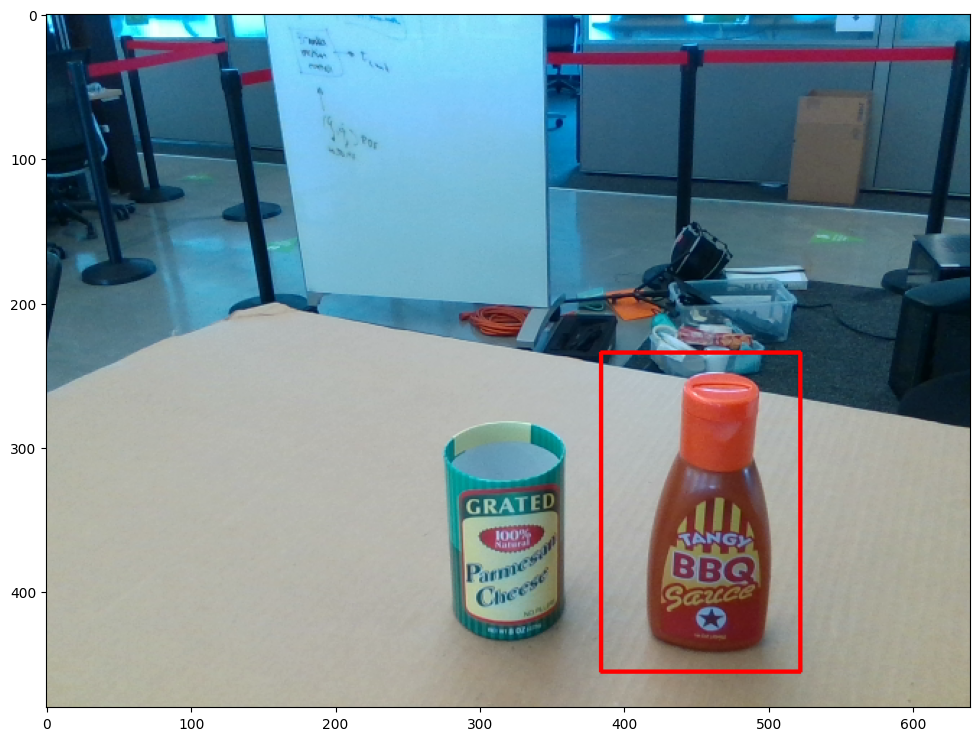

PandasTensorCollection(
    TCO: torch.Size([1, 4, 4]) torch.float32 cpu,
    bboxes: torch.Size([1, 4]) torch.float32 cpu,
    poses: torch.Size([1, 4, 4]) torch.float32 cpu,
    K: torch.Size([1, 3, 3]) torch.float64 cpu,
----------------------------------------
    infos:
         label  scene_id  view_id visib_fract  batch_im_id  score
0  hope_000002         0        9        None            0    1.0
)


In [3]:


ds_name = 'custom'
camera_name = 'camera_external'


# HOPE object
data_dir = LOCAL_DATA_DIR/'sensor_images'
im_idx = 9
object_label = 'hope_000002'
bbox_start = [384, 234]
bbox_size = [138, 221]


bbox = np.zeros(4)
bbox[:2] = bbox_start
bbox[2:] = bbox[:2] + np.array(bbox_size)
bboxes = torch.tensor(bbox).unsqueeze(0)
TWO = Transform(np.eye(4)) # placeholder
object_data = ObjectData(label=object_label, bbox_modal=bbox, TWO=TWO)


# Load the scene data and populate the object data
scene_data = load_data(im_idx, data_dir=data_dir)
scene_data.object_datas = [object_data]

data = SceneObservation.collate_fn([scene_data], object_labels=[object_label])
observation_tensor = ObservationTensor.from_numpy(scene_data.rgb, depth=scene_data.depth, K=scene_data.camera_data.K)
observation_tensor = observation_tensor.cuda()


# Filter gt_detections to only keep the object we are interested in

detections = data['gt_detections']

img = np.copy(scene_data.rgb)
img = draw_bounding_box(img, bbox)

plt.figure(figsize=(16,9))
plt.imshow(img)
plt.show()

print(detections)

scene_id = scene_data.infos.scene_id
view_id = scene_data.infos.view_id
TWC = scene_data.camera_data.TWC.matrix

## Load the model
- Choose which model to load (recommended to use the default `cfg.model_name = 'sn-gso-4views-normals'`.
- Select a depth refiner (robust-icp, TEASER++, None)

In [4]:
import megapose.inference.utils
cfg = OmegaConf.create()
cfg.model_name = 'sn-gso-4views-normals'
cfg.ds_name = ds_name
cfg.use_icp = False
depth_multiplier = None
per_iter_depth_multiplier = None
model_data = megapose.inference.utils.load_named_model(cfg, load_detector_flag=False)
result_name = cfg.model_name



refiner_model = model_data['refiner_model']
coarse_model = model_data['coarse_model']
obj_ds_name = model_data['obj_ds_name']
renderer = refiner_model.renderer

mesh_db = refiner_model.mesh_db



depth_refiner = None
depth_refiner_type = None
# depth_refiner_type = "icp"
# depth_refiner_type = "teaser++"

if depth_refiner_type == "icp":
    depth_refiner = ICPRefiner(mesh_db, renderer)
elif depth_refiner_type == "teaserpp":
    from megapose.inference.teaserpp_refiner import TeaserppRefiner
    depth_refiner = TeaserppRefiner(mesh_db, renderer)

pose_estimator = PoseEstimator(refiner_model=refiner_model,
                              coarse_model=coarse_model,
                               depth_refiner=depth_refiner,
                              )

Creating MeshDatabase
Done creating MeshDatabase
renderer_kwargs {'preload_cache': False, 'split_objects': False, 'n_workers': 8}


Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
No protocol specified
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
No protocol specified
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
No protocol specified
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
No protocol specified
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
No protocol specified
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
No protocol specified
0:00:03.218414 - Backbone: vanilla_resnet34
INFO - 2022-10-06 10:47:52,185 - pose_models_cfg - Backbone: vanilla_resnet34
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
No protocol specified
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
No protocol specified
0:00:03.551322 - Backbone: vanilla_resnet34
INFO - 2022-10-06 10:47:52,518 - pose_models_cfg -

## Run Model Inference

If you are getting CUDA out of memory errors decrease `bsz_objects` and `bsz_images` to smaller values.

In [5]:
# Options for inference
use_gt_detections = True 
n_refiner_iterations = 5
n_pose_hypotheses = 5
return_debug_data = True
detection_filter_kwargs = {'labels': [object_label]}
run_depth_refiner = True and (depth_refiner is not None) # Enable the depth refiner if it is not none


detections = detections.cuda()
# set the random seed
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)



with torch.no_grad():
    t = time.time()
    preds, pred_data = pose_estimator.run_inference_pipeline(observation_tensor,
                                                            detections=detections,
                                                            run_detector=True,
                                                            n_refiner_iterations=5,
                                                            n_pose_hypotheses=5,
                                                            detection_filter_kwargs=detection_filter_kwargs,
                                                            keep_all_refiner_outputs=True,
                                                            run_depth_refiner=run_depth_refiner,
                                                            cuda_timer=True,
                                                            bsz_objects=2,
                                                             bsz_images=128,
                                            
                                         )
    elapsed = time.time() - t
    
print(f"Inference times; {pred_data['timing_str']}")
# print(f"Running inference pipeline took {elapsed:.2f} seconds")
data_TCO_final = preds
print(preds)

/home/manuelli/Repos/nvidia/megapose/src/megapose/inference/utils.py:257: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby(["batch_im_id", "label"]).apply(lambda df: create_instance_id(df))


Inference times; total=3.32, coarse=2.85, refiner=0.43, scoring=0.02, 
PandasTensorCollection(
    poses: torch.Size([1, 4, 4]) torch.float32 cuda:0,
    poses_input: torch.Size([1, 4, 4]) torch.float32 cuda:0,
    K_crop: torch.Size([1, 3, 3]) torch.float32 cuda:0,
    K: torch.Size([1, 3, 3]) torch.float32 cuda:0,
    confidence: torch.Size([1]) torch.float32 cuda:0,
    boxes_rend: torch.Size([1, 4]) torch.float32 cuda:0,
    boxes_crop: torch.Size([1, 4]) torch.float32 cuda:0,
----------------------------------------
    infos:
         label  scene_id  view_id visib_fract  batch_im_id  score  \
0  hope_000002         0        9        None            0    1.0   

   instance_id  hypothesis_id  bbox_id  coarse_logit  coarse_score  \
0            0             73        0      0.791539      0.688162   

   refiner_batch_idx  refiner_instance_idx  confidence  verification_score  \
0                  1                     0         0.0                  -1   

   pose_logit  pose_score

## Print timing data

In [6]:
print(f"Inference pipeline: {pred_data['timing_str']}")
print(f"Coarse model: {pred_data['coarse']['data']['timing_str']}")

Inference pipeline: total=3.32, coarse=2.85, refiner=0.43, scoring=0.02, 
Coarse model: time: 2.85, model_time: 1.16, render_time: 1.23


In [7]:
# Extract some data from the inference output

refiner_outputs = pred_data['refiner']['data']['outputs']


data_TCO_refiner = pred_data['refiner']['preds']
if 'depth_refiner' in pred_data:
    data_TCO_depth_refiner = pred_data['depth_refiner']['preds']
else:
    data_TCO_depth_refiner = None

## Extract data from refiner iterations

In [8]:
plotter = Plotter()

def plot_cosypose(data, data_TCO_final, refiner_outputs_in, object_label, 
                  plot_iter=[1, 2, 3, 4], scene_data=None):
#     orig_renderer = object_predictor.pose_predictor.refiner_model.renderer
#     object_predictor.pose_predictor.refiner_model.renderer = renderer
    
    rows = []
    outputs = []
    
    df = data_TCO_final.infos
    df_filter = df[df.label == object_label]
    assert len(df_filter) == 1, f"There was more than one object named {object_label} in refiner_preds"
    
    refiner_batch_idx = df_filter.iloc[0]['refiner_batch_idx']
    refiner_instance_idx = df_filter.iloc[0]["refiner_instance_idx"]
    

    df_gt = data['gt_detections'].infos
    df_gt_filter = df_gt[df_gt.label == object_label]
    
    assert len(df_gt_filter) == 1, f"There was more than one object named {object_label} in data['gt_detections']"
    obj_idx_gt = df_gt_filter.iloc[0].name
    TWC = scene_data.camera_data.TWC.matrix
    TCO_gt = data['gt_detections'].poses[obj_idx_gt].cpu().numpy().astype(np.float64)
    TOC_gt = np.linalg.inv(TCO_gt)
    
    
    if 'data_TCO_init' in all_preds:
        data_TCO_init = all_preds['data_TCO_init']
        df = data_TCO_init.infos
        df = df[df.label == object_label]
        idx_tmp = df.index[0]
        TCO_coarse_init = cast_to_numpy(data_TCO_init.poses[idx_tmp], np.float64)
    else:
        TCO_coarse_init = None
    
    

    for n in plot_iter:
        refiner_outputs_iter = refiner_outputs_in[refiner_batch_idx][f'iteration={n}']
        image_crop = refiner_outputs[refiner_batch_idx][f'iteration={n}']['images_crop']\
            [refiner_instance_idx][RGB_DIMS]
        render_crop = refiner_outputs[refiner_batch_idx][f'iteration={n}']['renders']\
            [refiner_instance_idx][RGB_DIMS]

        image_crop = (image_crop.permute(1, 2, 0) * 255).cpu().numpy().astype(np.uint8)
        render_crop = (render_crop.permute(1, 2, 0) * 255).cpu().numpy().astype(np.uint8)

        image_f = plotter.plot_image(image_crop)
        render_f = plotter.plot_image(render_crop)
        overlay_f = plotter.plot_overlay(image_crop, render_crop)
        row = [image_f, render_f, overlay_f]
        TCO_pred = refiner_outputs[refiner_batch_idx][f'iteration={n}']['TCO_input'][refiner_instance_idx].cpu().numpy()
        TCO_output = refiner_outputs[refiner_batch_idx][f'iteration={n}']['TCO_input'][refiner_instance_idx].cpu().numpy()
        
        
        # compute errors
        TCO_pred = orthogonalize_rotation(TCO_pred)
        TOgt_O = np.linalg.inv(TCO_gt) @ TCO_pred
        TOgt_O = orthogonalize_rotation(TOgt_O)
        trans_err = np.linalg.norm(TOgt_O[:3,3])
        
        
        # Compute coarse score
        rgb = data['rgb']
        depth = data['depth']

        # [B,C,H,W], C=3 or 4 depending on if depth was empty or not
        # Compute score from coarse model
        images = cast_images_to_tensor(rgb, depth)
        K = data['cameras'].K.cuda().float()
        label = [object_label]
        TCO_pred_tensor = torch.tensor(TCO_pred).cuda().unsqueeze(0)
        out_ = coarse_model.forward_coarse(images, K, label, TCO_input=TCO_pred_tensor, 
                                           return_debug_data=True)
        
        coarse_out = out_
        
        
        try:
            _, rot_err_angle_radians = transforms3d.axangles.mat2axangle(TOgt_O[:3,:3])
            rot_err_deg = np.rad2deg(np.abs(rot_err_angle_radians))
        except ValueError:
            print("got error while computing angle distance")
            rot_err_deg = -1
        



        infos = dict(figures=row, 
                     TCO_output=TCO_output,
                     TCO_input=TCO_pred,
                     TCO_gt=TCO_gt,
                     TOC_gt=TOC_gt,
                     TOgt_O=TOgt_O,
                     label=object_label,
                     refiner_batch_idx=refiner_batch_idx,
                     refiner_instance_idx=refiner_instance_idx,
                     iteration=n,
                     refiner_outputs=refiner_outputs_iter,
                     scene_data=scene_data,
                     input_rgb_dims=copy.copy(refiner_model.input_rgb_dims),
                     input_depth_dims=copy.copy(refiner_model.input_depth_dims),
                     render_rgb_dims=copy.copy(refiner_model.render_rgb_dims),
                     render_depth_dims=copy.copy(refiner_model.render_depth_dims),
                     TCO_coarse_init=TCO_coarse_init,
                     trans_err=trans_err,
                     rot_err=rot_err_deg,
                     coarse_out=coarse_out,
#                      TCO_coarse_init=TCO_coarse_init,
#                      object_predictor_data=object_predictor_data,
                    )
        outputs.append(infos)
        
    return outputs




plot_iter = [1, 2, 3,4,5,6]
plot_iter = list(range(1, n_refiner_iterations+1))
# plot_iter = [1,2,3,4,5,6,7,8]
all_preds = preds
all_infos = plot_cosypose(data, data_TCO_final, refiner_outputs,
                          object_label, plot_iter, scene_data=scene_data)

for info in all_infos:
    info['result_name'] = result_name
all_infos = pd.DataFrame(all_infos)

# save_path = NB_DATA_DIR / f'{result_name}_ds_name={ds_name}_scene_id={scene_id}_im={view_id}_object_label={object_label}.pkl'
# save_path.write_bytes(pkl.dumps(all_infos.drop(columns=('figures'))))
# print("wrote", save_path)

## Visualize Refiner iterations

In [9]:



grid = []
# plot_iter = [1,2,3,4,5,6,7,8]
plot_object_label = object_label
df = all_infos.copy()
df = df.loc[(df['iteration'].isin(plot_iter)) & (df['label'] == object_label)]
for _, row in df.iterrows():
    figures = row['figures']
    result_name = row['result_name']
    k = row['iteration']
    figures[1].title.text = f'{result_name} / iter={k}'
    figures[2].title.text_font_size = '12pt'
    grid.append(figures)
show(gridplot(grid, sizing_mode='scale_width'))

## Make contour overlay figure

Overlay ground-truth and estimated pose

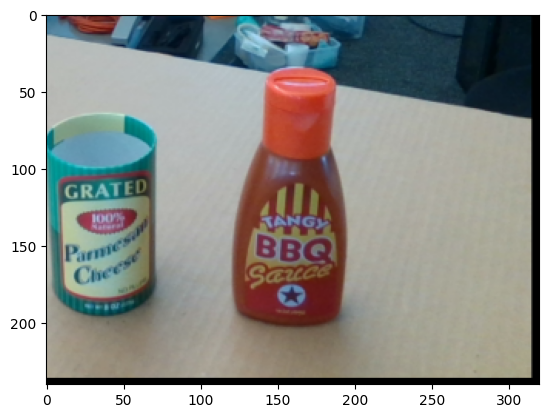

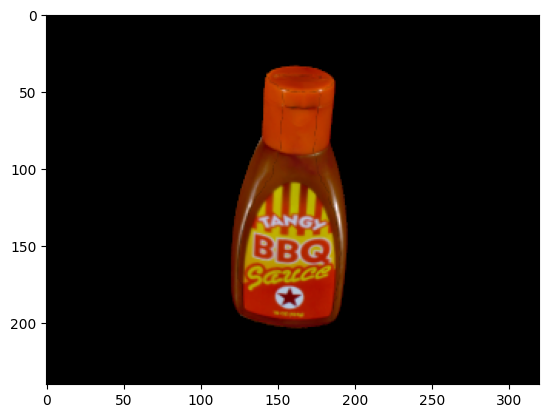

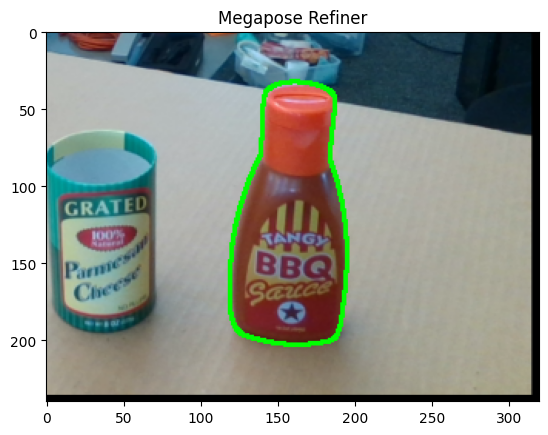

In [10]:

SAVE_DIR = NB_DATA_DIR/'figures'
SAVE_DIR.mkdir(parents=True, exist_ok=True)


ambient_light_data = Panda3dLightData('ambient')
light_datas = [[ambient_light_data]]


# Need to render an image at the ground-truth pose
d = dict()
for n in [n_refiner_iterations]:
    
    # Initial coarse estimate
    x = refiner_outputs[0][f'iteration={n}']
    render_img_tensor = x['renders'][0,0:3]
    render_img = tensor_image_to_uint8(render_img_tensor)
    render_img_PIL = Image.fromarray(render_img)
    render_img_PIL = adjust_brightness(render_img_PIL, factor=BRIGHTNESS_FACTOR)
    render_img_PIL.save(f'{SAVE_DIR}/refiner_iter={n}_render.png')


    img_tensor = x['images_crop'][0, 0:3]
    img = tensor_image_to_uint8(img_tensor)
    img_PIL = Image.fromarray(img)

    img_PIL.save(SAVE_DIR/f"refiner_iter={n}_img_crop.png")

    blend = Plotter.make_overlay(img, np.array(render_img_PIL))
    
    contour_out = make_contour_overlay(img, np.array(render_img_PIL), dilate_iterations=1, color=[0,255,0])
    contour = contour_out['img']
    
#     contour_both = make_contour_overlay(img, np.array(render_img_PIL), color=[255,0,0],
#                                        dilate_iterations=0)['img']
    
    
    d[n] = {'render': np.array(render_img_PIL),
           'img': img,
           'blend': blend,
           'contour': contour,
           'contour_out': contour_out,
           }
    



plt.figure()
plt.imshow(d[n_refiner_iterations]['img'])
plt.show()

plt.figure()
plt.imshow(d[n_refiner_iterations]['render'])
plt.show()

plt.figure()
plt.imshow(d[n_refiner_iterations]['contour_out']['img'])
plt.title("Megapose Refiner")
plt.show()



    

## 3D visualization using meshcat.

Make sure you have a `meshcat-server` process running on the host machine. Otherwise this code will hang.

In [11]:
from megapose.visualization import meshcat_utils
from megapose.visualization.meshcat_visualizer import MeshcatSceneViewer
import meshcat.geometry as g
vis = meshcat_utils.create_visualizer()

df = all_infos
show_iter = [n_refiner_iterations]
df = df.loc[(df['iteration'].isin(show_iter))]

viewer = MeshcatSceneViewer(obj_ds_name, use_textures=True,)
# viewer = MeshcatSceneViewer('ycbv', use_textures=False) # debugging
vis = viewer.visualizer

def extract_pointcloud_from_scene_data(scene_data):
    depth = scene_data.depth
    K = scene_data.camera_data.K
    pc = meshcat_utils.get_pointcloud(depth, K)    
    
    return pc


def extract_pointclouds(iter_info):
    refiner_outputs = iter_info['refiner_outputs']
    unique_id = iter_info['refiner_instance_idx']
    image_crop_raw = refiner_outputs['images_crop_raw'][unique_id]
    render_raw = refiner_outputs['renders_raw'][unique_id]
    K_crop = refiner_outputs['K_crop'][unique_id].cpu().numpy()
    KV_crop = refiner_outputs['KV_crop'][unique_id][0].cpu().numpy()
    TCO_input = refiner_outputs['TCO_input'][unique_id].cpu().numpy()

    input_depth_dims = iter_info['input_depth_dims']
    render_depth_dims = iter_info['render_depth_dims']
    if len(input_depth_dims) > 0:
        input_depth = image_crop_raw[input_depth_dims].permute(1,2,0).cpu().squeeze().numpy()
        gt_pc = meshcat_utils.get_pointcloud(input_depth, K_crop)    
    else:
        gt_pc = None
        
        
    if len(render_depth_dims) > 0:
        render_depth = render_raw[render_depth_dims].permute(1,2,0).cpu().squeeze().numpy()
        render_pc = meshcat_utils.get_pointcloud(render_depth, KV_crop)    
    else:
        render_pc = None
        
        
    return {'gt': gt_pc,
           'render': render_pc,
            'TCO_input': TCO_input,
           }
        
def plot_results(df):
    df = df.to_dict('records')
    
    obj_infos = []
    
    obj_label = df[0]['label']
    # Visualize camera
        
    for row in df:
        meshcat_prefix = f"{row['result_name']}"
        TWO = TWC @ row['TCO_input']
        k = f"{row['result_name']}/iteration={row['iteration']}/mesh"
        obj_infos.append({'name': obj_label, 'TWO': TWO, 'node_name': k})
        
        
    if data_TCO_depth_refiner is not None:
        df_ = data_TCO_depth_refiner.infos
        idx = df_[df_.label == object_label].iloc[0].name
        TCO_depth_refiner = data_TCO_depth_refiner.poses[idx].cpu().numpy()
        TWO = TWC @ TCO_depth_refiner
        k = f"{row['result_name']}/depth_refiner/mesh"
        obj_infos.append({'name': obj_label, 'TWO': TWO, 'node_name': k})
        
        

    viewer.visualize_scene(obj_infos)
    
    # Extra visualization must be after the 'visualize_scene' call
    meshcat_utils.make_frame(vis, "camera", transform=TWC, ignore_invalid_transform=True)
    
    # Line connecting camera and origin
    vertices = np.zeros([3,2])
    vertices[:, 1] = TWC[:3,3]
    vis['line'].set_object(g.Line(g.PointsGeometry(vertices)))
    
    
    # visualize ground-truth pointcloud
    pc_gt = extract_pointcloud_from_scene_data(df[0]['scene_data'])
    meshcat_utils.visualize_pointcloud(vis, 'ground_truth_pointcloud', pc_gt, transform=TWC,
                                              color=[0,255,0])
    
    
    # visualize depth images, but only for final index
    for row in df:
        pc_data = extract_pointclouds(row)
        f"{row['result_name']}/iteration={row['iteration']}"
#         if pc_data['gt'] is not None:
#             print("Visualizing ground-truth pointcloud")
#             meshcat_utils.visualize_pointcloud(vis, 'ground_truth_pointcloud', pc_data['gt'], transform=TOC_gt,
#                                               color=[0,255,0])
            
        if pc_data['render'] is not None:        
            TWO = TWC @ pc_data['TCO_input']
            k = f"{row['result_name']}/iteration={row['iteration']}/pointcloud"
            meshcat_utils.visualize_pointcloud(vis, k, pc_data['render'],
                                               transform=TWO, color=[255,255,0])
        
    return

plot_results(df)

Waiting for meshcat server... have you started a server? Run `meshcat-server` to start a server. Communicating on zmq_url=tcp://127.0.0.1:6000
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Created meschat visualizer!
Waiting for meshcat server... have you started a server? Run `meshcat-server` to start a server. Communicating on zmq_url=tcp://127.0.0.1:6000
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Created meschat visualizer!
